# Resnet50

## Installing & Importing Necessary Libraries

In [1]:
!pip install -q wandb

In [3]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import wandb
wandb.login()
import os
import pandas as pd
import matplotlib.pyplot as plt

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# Using W&B for better logging and visualizations
wandb.init(project="wound-classification-Resnet50", config={
    "learning_rate": 0.001,
    "architecture": "Resnet50"
})

wandb: Currently logged in as: mrinoy-banerjee (aipi549). Use `wandb login --relogin` to force relogin


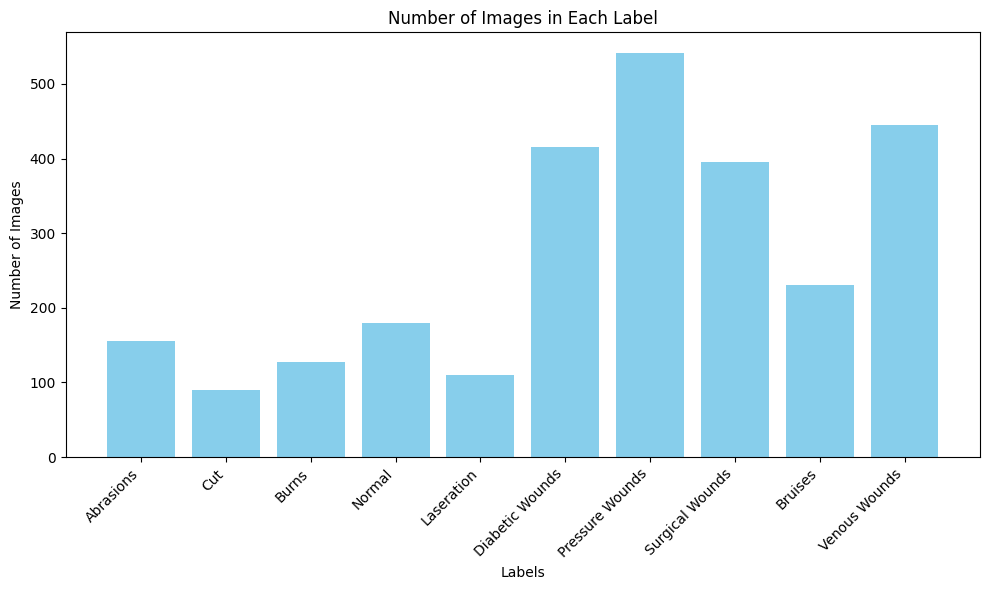

In [5]:
# Path to your dataset directory
data_dir = '/kaggle/input/wounddataset1/WoundDataset/train'

# List all the images in the dataset directory
labels = os.listdir(data_dir)

# Initialize a dictionary to store the count of images in each label
label_count = {}

# Count the number of images in each label
for label in labels:
    label_path = os.path.join(data_dir, label)
    num_images = len(os.listdir(label_path))
    label_count[label] = num_images

# Create a bar graph to visualize the count of images in each label
plt.figure(figsize=(10, 6))
plt.bar(label_count.keys(), label_count.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing

Data Transformations

In [12]:
def preprocess(data_dir):
    """
    Preprocesses images in the specified directory.

    Args:
    - data_dir (str): Path to the dataset directory.

    Returns:
    - dataset (torchvision.datasets.ImageFolder): Preprocessed dataset.
    """
    # Define transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ])

    # Create a dataset from the images in the specified directory
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    return dataset

## Modelling

Train & Validate functions

In [16]:
import torch
from tqdm import tqdm
import wandb  # Ensure wandb is installed or remove wandb logging if not using

def train_resnet50(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path):
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct / total

        print(f"Epoch {epoch+1}/{epochs}.. " f"Train loss: {train_loss:.3f}.. " f"Train accuracy: {train_accuracy:.3f}")

        val_loss, val_accuracy = validate_resnet50(model, device, valloader, criterion)

        print(f"Validation loss: {val_loss:.3f}.. " f"Validation accuracy: {val_accuracy:.3f}")

        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_accuracy,
                   "val_loss": val_loss, "val_accuracy": val_accuracy})

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("Model saved.")

    print('Training finished!')


def validate_resnet50(model, device, valloader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valloader, desc='Validation', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy

In [17]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import torchvision.models as models
from torch import nn
import wandb  # Ensure wandb is installed or remove wandb logging if not using

# Assuming preprocess function and dataset are compatible with Inception v3 input requirements

# Assuming preprocess function and dataset are compatible with ResNet50 input requirements
start_time = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = '/kaggle/input/wounddataset1/WoundDataset/train'
dataset = preprocess(data_dir)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
criterion = nn.CrossEntropyLoss()

for fold, (train_index, val_index) in enumerate(skf.split(dataset.imgs, dataset.targets)):
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)

    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(set(dataset.targets)))  # Dynamically adjust based on unique labels
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    wandb.init(project="wound-classification-Resnet50", name=f"fold_{fold}")
    model_path = f'/kaggle/working/Resnet50_model_fold_{fold}.pth'

    train_resnet50(model, device, trainloader, valloader, criterion, optimizer, 15, model_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time taken: {elapsed_time} seconds")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,▁▂▃▄▅▆▇█
train_accuracy,▁▄▅▆▆▆██
train_loss,█▅▄▃▃▃▁▁
val_accuracy,▁▃▄▅▁█▇█
val_loss,█▆▄▄▆▂▂▁
epoch,8
train_accuracy,75.13941
train_loss,0.69344
val_accuracy,70.68646
val_loss,0.79181


Epoch 1/15: 100%|██████████| 68/68 [00:29<00:00,  2.34batch/s]


Epoch 1/15.. Train loss: 1.649.. Train accuracy: 42.565


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.91batch/s]


Validation loss: 1.904.. Validation accuracy: 39.518
Model saved.


Epoch 2/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 2/15.. Train loss: 1.317.. Train accuracy: 53.067


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.86batch/s]


Validation loss: 1.304.. Validation accuracy: 53.061
Model saved.


Epoch 3/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 3/15.. Train loss: 1.181.. Train accuracy: 57.388


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.79batch/s]


Validation loss: 1.576.. Validation accuracy: 46.753


Epoch 4/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 4/15.. Train loss: 1.036.. Train accuracy: 61.571


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.65batch/s]


Validation loss: 1.085.. Validation accuracy: 59.926
Model saved.


Epoch 5/15: 100%|██████████| 68/68 [00:26<00:00,  2.57batch/s]


Epoch 5/15.. Train loss: 0.941.. Train accuracy: 66.543


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s]


Validation loss: 1.101.. Validation accuracy: 62.523


Epoch 6/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 6/15.. Train loss: 0.877.. Train accuracy: 67.612


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.63batch/s]


Validation loss: 1.099.. Validation accuracy: 64.378


Epoch 7/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 7/15.. Train loss: 0.778.. Train accuracy: 72.723


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.65batch/s]


Validation loss: 1.042.. Validation accuracy: 64.935
Model saved.


Epoch 8/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 8/15.. Train loss: 0.774.. Train accuracy: 72.351


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.62batch/s]


Validation loss: 0.846.. Validation accuracy: 70.686
Model saved.


Epoch 9/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 9/15.. Train loss: 0.708.. Train accuracy: 74.442


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s]


Validation loss: 0.981.. Validation accuracy: 66.976


Epoch 10/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 10/15.. Train loss: 0.621.. Train accuracy: 77.416


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.75batch/s]


Validation loss: 0.806.. Validation accuracy: 73.098
Model saved.


Epoch 11/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 11/15.. Train loss: 0.549.. Train accuracy: 80.204


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.80batch/s]


Validation loss: 0.718.. Validation accuracy: 77.365
Model saved.


Epoch 12/15: 100%|██████████| 68/68 [00:25<00:00,  2.62batch/s]


Epoch 12/15.. Train loss: 0.579.. Train accuracy: 79.554


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s]


Validation loss: 0.693.. Validation accuracy: 78.293
Model saved.


Epoch 13/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 13/15.. Train loss: 0.508.. Train accuracy: 82.714


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s]


Validation loss: 0.750.. Validation accuracy: 77.551


Epoch 14/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 14/15.. Train loss: 0.579.. Train accuracy: 79.368


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.70batch/s]


Validation loss: 0.863.. Validation accuracy: 73.840


Epoch 15/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 15/15.. Train loss: 0.416.. Train accuracy: 84.712


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.66batch/s]


Validation loss: 0.645.. Validation accuracy: 79.406
Model saved.
Training finished!


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▃▄▅▅▆▆▆▇▇▇█▇█
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁
val_accuracy,▁▃▂▅▅▅▅▆▆▇███▇█
val_loss,█▅▆▃▄▄▃▂▃▂▁▁▂▂▁
epoch,15
train_accuracy,84.7119
train_loss,0.41611
val_accuracy,79.40631
val_loss,0.64494


Epoch 1/15: 100%|██████████| 68/68 [00:28<00:00,  2.36batch/s]


Epoch 1/15.. Train loss: 1.649.. Train accuracy: 42.081


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.67batch/s]


Validation loss: 1.909.. Validation accuracy: 42.379
Model saved.


Epoch 2/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 2/15.. Train loss: 1.293.. Train accuracy: 53.414


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.51batch/s]


Validation loss: 1.565.. Validation accuracy: 46.654
Model saved.


Epoch 3/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 3/15.. Train loss: 1.092.. Train accuracy: 60.938


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s]


Validation loss: 1.492.. Validation accuracy: 52.045
Model saved.


Epoch 4/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 4/15.. Train loss: 1.040.. Train accuracy: 63.493


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.66batch/s]


Validation loss: 1.077.. Validation accuracy: 62.454
Model saved.


Epoch 5/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 5/15.. Train loss: 0.894.. Train accuracy: 66.837


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.62batch/s]


Validation loss: 0.952.. Validation accuracy: 67.286
Model saved.


Epoch 6/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 6/15.. Train loss: 0.788.. Train accuracy: 72.271


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s]


Validation loss: 1.101.. Validation accuracy: 64.870


Epoch 7/15: 100%|██████████| 68/68 [00:26<00:00,  2.61batch/s]


Epoch 7/15.. Train loss: 0.752.. Train accuracy: 71.946


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s]


Validation loss: 1.143.. Validation accuracy: 59.665


Epoch 8/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 8/15.. Train loss: 0.707.. Train accuracy: 74.826


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s]


Validation loss: 0.994.. Validation accuracy: 68.030


Epoch 9/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 9/15.. Train loss: 0.623.. Train accuracy: 77.798


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s]


Validation loss: 0.791.. Validation accuracy: 72.305
Model saved.


Epoch 10/15: 100%|██████████| 68/68 [00:26<00:00,  2.57batch/s]


Epoch 10/15.. Train loss: 0.595.. Train accuracy: 79.238


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s]


Validation loss: 0.771.. Validation accuracy: 73.048
Model saved.


Epoch 11/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 11/15.. Train loss: 0.482.. Train accuracy: 82.257


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.70batch/s]


Validation loss: 1.047.. Validation accuracy: 69.331


Epoch 12/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 12/15.. Train loss: 0.494.. Train accuracy: 82.815


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s]


Validation loss: 0.789.. Validation accuracy: 73.978


Epoch 13/15: 100%|██████████| 68/68 [00:25<00:00,  2.62batch/s]


Epoch 13/15.. Train loss: 0.507.. Train accuracy: 82.815


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.59batch/s]


Validation loss: 0.784.. Validation accuracy: 72.305


Epoch 14/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 14/15.. Train loss: 0.451.. Train accuracy: 83.697


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.47batch/s]


Validation loss: 0.752.. Validation accuracy: 75.836
Model saved.


Epoch 15/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 15/15.. Train loss: 0.404.. Train accuracy: 86.484


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.54batch/s]


Validation loss: 0.652.. Validation accuracy: 78.625
Model saved.
Training finished!


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇██
train_loss,█▆▅▅▄▃▃▃▂▂▁▂▂▁▁
val_accuracy,▁▂▃▅▆▅▄▆▇▇▆▇▇▇█
val_loss,█▆▆▃▃▄▄▃▂▂▃▂▂▂▁
epoch,15
train_accuracy,86.48398
train_loss,0.40389
val_accuracy,78.62454
val_loss,0.6516


Epoch 1/15: 100%|██████████| 68/68 [00:29<00:00,  2.32batch/s]


Epoch 1/15.. Train loss: 1.644.. Train accuracy: 42.545


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.78batch/s]


Validation loss: 1.510.. Validation accuracy: 51.301
Model saved.


Epoch 2/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 2/15.. Train loss: 1.258.. Train accuracy: 55.736


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.91batch/s]


Validation loss: 1.966.. Validation accuracy: 47.955


Epoch 3/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 3/15.. Train loss: 1.184.. Train accuracy: 56.804


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.77batch/s]


Validation loss: 1.232.. Validation accuracy: 58.178
Model saved.


Epoch 4/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 4/15.. Train loss: 0.988.. Train accuracy: 64.422


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.76batch/s]


Validation loss: 1.235.. Validation accuracy: 61.152


Epoch 5/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 5/15.. Train loss: 0.918.. Train accuracy: 66.465


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.73batch/s]


Validation loss: 1.025.. Validation accuracy: 61.710
Model saved.


Epoch 6/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 6/15.. Train loss: 0.832.. Train accuracy: 71.528


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.91batch/s]


Validation loss: 1.556.. Validation accuracy: 48.885


Epoch 7/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 7/15.. Train loss: 0.818.. Train accuracy: 70.135


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.90batch/s]


Validation loss: 1.101.. Validation accuracy: 61.710


Epoch 8/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 8/15.. Train loss: 0.675.. Train accuracy: 76.359


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.92batch/s]


Validation loss: 1.036.. Validation accuracy: 61.524


Epoch 9/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 9/15.. Train loss: 0.654.. Train accuracy: 76.869


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.88batch/s]


Validation loss: 0.889.. Validation accuracy: 70.446
Model saved.


Epoch 10/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 10/15.. Train loss: 0.646.. Train accuracy: 76.405


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.90batch/s]


Validation loss: 0.784.. Validation accuracy: 72.677
Model saved.


Epoch 11/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 11/15.. Train loss: 0.632.. Train accuracy: 77.938


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.91batch/s]


Validation loss: 0.887.. Validation accuracy: 71.933


Epoch 12/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 12/15.. Train loss: 0.540.. Train accuracy: 81.886


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.80batch/s]


Validation loss: 0.890.. Validation accuracy: 71.375


Epoch 13/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 13/15.. Train loss: 0.470.. Train accuracy: 82.768


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.88batch/s]


Validation loss: 0.911.. Validation accuracy: 71.004


Epoch 14/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 14/15.. Train loss: 0.471.. Train accuracy: 82.908


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.80batch/s]


Validation loss: 0.774.. Validation accuracy: 74.721
Model saved.


Epoch 15/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 15/15.. Train loss: 0.396.. Train accuracy: 85.694


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.76batch/s]


Validation loss: 0.584.. Validation accuracy: 80.855
Model saved.
Training finished!


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▃▅▅▆▅▆▇▆▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▂▁▃▄▄▁▄▄▆▆▆▆▆▇█
val_loss,▆█▄▄▃▆▄▃▃▂▃▃▃▂▁
epoch,15
train_accuracy,85.69438
train_loss,0.39622
val_accuracy,80.85502
val_loss,0.58368


Epoch 1/15: 100%|██████████| 68/68 [00:29<00:00,  2.34batch/s]


Epoch 1/15.. Train loss: 1.737.. Train accuracy: 40.502


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.82batch/s]


Validation loss: 2.876.. Validation accuracy: 32.342
Model saved.


Epoch 2/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 2/15.. Train loss: 1.284.. Train accuracy: 53.600


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.76batch/s]


Validation loss: 1.473.. Validation accuracy: 50.743
Model saved.


Epoch 3/15: 100%|██████████| 68/68 [00:26<00:00,  2.54batch/s]


Epoch 3/15.. Train loss: 1.238.. Train accuracy: 56.386


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.86batch/s]


Validation loss: 1.446.. Validation accuracy: 51.673
Model saved.


Epoch 4/15: 100%|██████████| 68/68 [00:26<00:00,  2.57batch/s]


Epoch 4/15.. Train loss: 1.041.. Train accuracy: 61.542


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s]


Validation loss: 1.167.. Validation accuracy: 60.223
Model saved.


Epoch 5/15: 100%|██████████| 68/68 [00:26<00:00,  2.54batch/s]


Epoch 5/15.. Train loss: 0.972.. Train accuracy: 66.280


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.82batch/s]


Validation loss: 1.036.. Validation accuracy: 59.480
Model saved.


Epoch 6/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 6/15.. Train loss: 0.847.. Train accuracy: 70.228


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.70batch/s]


Validation loss: 1.188.. Validation accuracy: 56.877


Epoch 7/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 7/15.. Train loss: 0.850.. Train accuracy: 68.741


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.77batch/s]


Validation loss: 1.091.. Validation accuracy: 60.967


Epoch 8/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 8/15.. Train loss: 0.752.. Train accuracy: 72.503


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.67batch/s]


Validation loss: 0.848.. Validation accuracy: 70.260
Model saved.


Epoch 9/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 9/15.. Train loss: 0.659.. Train accuracy: 76.451


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s]


Validation loss: 0.813.. Validation accuracy: 71.933
Model saved.


Epoch 10/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 10/15.. Train loss: 0.644.. Train accuracy: 77.195


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.82batch/s]


Validation loss: 0.805.. Validation accuracy: 71.747
Model saved.


Epoch 11/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 11/15.. Train loss: 0.582.. Train accuracy: 78.820


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.84batch/s]


Validation loss: 0.778.. Validation accuracy: 74.164
Model saved.


Epoch 12/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 12/15.. Train loss: 0.557.. Train accuracy: 80.539


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s]


Validation loss: 0.913.. Validation accuracy: 68.959


Epoch 13/15: 100%|██████████| 68/68 [00:26<00:00,  2.57batch/s]


Epoch 13/15.. Train loss: 0.495.. Train accuracy: 81.654


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.84batch/s]


Validation loss: 0.798.. Validation accuracy: 71.561


Epoch 14/15: 100%|██████████| 68/68 [00:26<00:00,  2.55batch/s]


Epoch 14/15.. Train loss: 0.466.. Train accuracy: 82.443


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s]


Validation loss: 0.670.. Validation accuracy: 76.022
Model saved.


Epoch 15/15: 100%|██████████| 68/68 [00:26<00:00,  2.57batch/s]


Epoch 15/15.. Train loss: 0.478.. Train accuracy: 82.861


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.78batch/s]


Validation loss: 0.627.. Validation accuracy: 78.067
Model saved.
Training finished!


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▄▅▆▆▆▇▇▇████
train_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▅▅▇▇▇▇▇▇██
val_loss,█▄▄▃▂▃▂▂▂▂▁▂▂▁▁
epoch,15
train_accuracy,82.86112
train_loss,0.47797
val_accuracy,78.06691
val_loss,0.62657


Epoch 1/15: 100%|██████████| 68/68 [00:28<00:00,  2.40batch/s]


Epoch 1/15.. Train loss: 1.612.. Train accuracy: 44.635


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.46batch/s]


Validation loss: 1.423.. Validation accuracy: 53.532
Model saved.


Epoch 2/15: 100%|██████████| 68/68 [00:26<00:00,  2.61batch/s]


Epoch 2/15.. Train loss: 1.295.. Train accuracy: 53.646


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.51batch/s]


Validation loss: 1.389.. Validation accuracy: 50.000
Model saved.


Epoch 3/15: 100%|██████████| 68/68 [00:26<00:00,  2.61batch/s]


Epoch 3/15.. Train loss: 1.129.. Train accuracy: 59.684


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.48batch/s]


Validation loss: 1.233.. Validation accuracy: 55.019
Model saved.


Epoch 4/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 4/15.. Train loss: 0.991.. Train accuracy: 63.725


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.46batch/s]


Validation loss: 1.057.. Validation accuracy: 65.242
Model saved.


Epoch 5/15: 100%|██████████| 68/68 [00:26<00:00,  2.58batch/s]


Epoch 5/15.. Train loss: 0.919.. Train accuracy: 66.280


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.43batch/s]


Validation loss: 1.142.. Validation accuracy: 62.825


Epoch 6/15: 100%|██████████| 68/68 [00:26<00:00,  2.61batch/s]


Epoch 6/15.. Train loss: 0.846.. Train accuracy: 69.577


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.57batch/s]


Validation loss: 1.272.. Validation accuracy: 57.807


Epoch 7/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 7/15.. Train loss: 0.757.. Train accuracy: 73.340


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.46batch/s]


Validation loss: 1.009.. Validation accuracy: 69.331
Model saved.


Epoch 8/15: 100%|██████████| 68/68 [00:26<00:00,  2.57batch/s]


Epoch 8/15.. Train loss: 0.760.. Train accuracy: 71.946


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.49batch/s]


Validation loss: 0.841.. Validation accuracy: 69.703
Model saved.


Epoch 9/15: 100%|██████████| 68/68 [00:26<00:00,  2.56batch/s]


Epoch 9/15.. Train loss: 0.601.. Train accuracy: 79.517


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.42batch/s]


Validation loss: 0.987.. Validation accuracy: 69.888


Epoch 10/15: 100%|██████████| 68/68 [00:26<00:00,  2.61batch/s]


Epoch 10/15.. Train loss: 0.593.. Train accuracy: 79.099


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.58batch/s]


Validation loss: 0.845.. Validation accuracy: 71.933


Epoch 11/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 11/15.. Train loss: 0.557.. Train accuracy: 80.028


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.43batch/s]


Validation loss: 0.750.. Validation accuracy: 75.093
Model saved.


Epoch 12/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 12/15.. Train loss: 0.559.. Train accuracy: 80.028


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.52batch/s]


Validation loss: 0.990.. Validation accuracy: 70.260


Epoch 13/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 13/15.. Train loss: 0.481.. Train accuracy: 83.047


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.43batch/s]


Validation loss: 0.866.. Validation accuracy: 73.606


Epoch 14/15: 100%|██████████| 68/68 [00:26<00:00,  2.59batch/s]


Epoch 14/15.. Train loss: 0.408.. Train accuracy: 85.137


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.62batch/s]


Validation loss: 0.706.. Validation accuracy: 79.740
Model saved.


Epoch 15/15: 100%|██████████| 68/68 [00:26<00:00,  2.60batch/s]


Epoch 15/15.. Train loss: 0.413.. Train accuracy: 85.927


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.44batch/s]


Validation loss: 0.602.. Validation accuracy: 83.271
Model saved.
Training finished!
Total time taken: 2534.0034549236298 seconds


## Plots

Train & Validation Accuracy; Train & Validation Loss is in W&B graphs

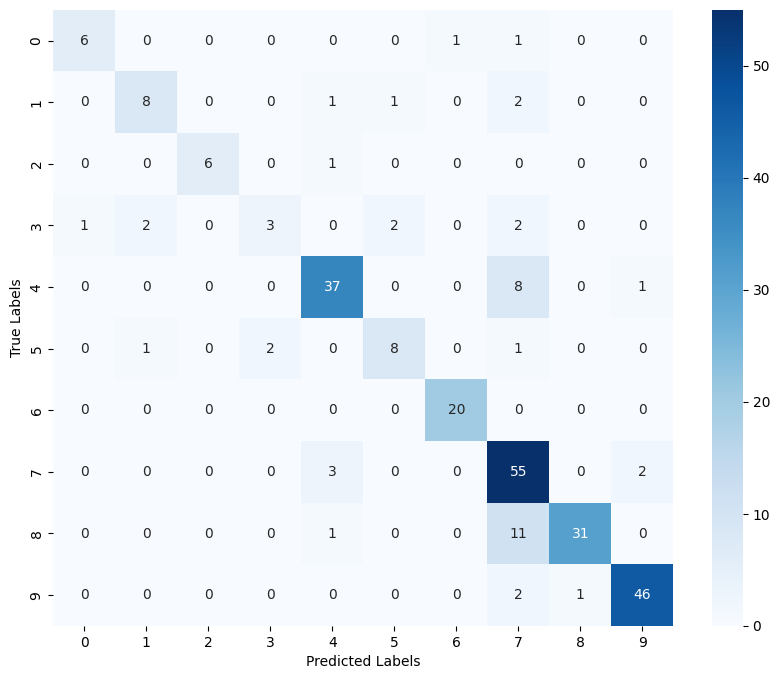

In [20]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

# Assuming device has been defined
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model without pretrained weights and disable auxiliary logits
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) 

# Load the saved state dict into the model
model.load_state_dict(torch.load(best_model_path, map_location=device))

#model = model.to(device)
model.eval()

# Load and preprocess the test data
data_dir = '/kaggle/input/wounddataset1/WoundDataset/test'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(data_dir, transform=transform)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Prediction and Evaluation
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_pred_y and y_test are your predicted and actual labels respectively

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute precision
precision = precision_score(y_true, y_pred, average='weighted')

# Compute recall
recall = recall_score(y_true, y_pred, average='weighted')

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8239700374531835
Precision: 0.8383552627234793
Recall: 0.8239700374531835
F1 Score: 0.8215060549615805
